## Task 2 >> (imagine opening and closing the left or right fist) ---> subject_id [4,8,12]


In [ ]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pywt
from glob import glob
from mne.io import concatenate_raws
from mne.preprocessing import ICA
from sklearn.decomposition import FastICA
from scipy.linalg import eigh
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout, Permute, Conv1D, MaxPooling1D
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
# matplotlib.use('Qt5Agg')

In [ ]:
all_paths = glob(os.path.join('/content/drive/MyDrive/data', '**', '*.edf'), recursive=True)
# all_paths[0].split('\\')[2][5:7]

In [ ]:
import random # Shuffle the list in-place
random.seed(1)

task2_04_paths = [path for path in all_paths if '04' in path.split('/')[-1][5:7]]
random.shuffle(task2_04_paths)
task2_04_paths = task2_04_paths[:105]
######################################################
task2_08_paths = [path for path in all_paths if '08' in path.split('/')[-1][5:7]]
random.shuffle(task2_08_paths)
task2_08_paths = task2_08_paths[:105]
######################################################
task2_12_paths = [path for path in all_paths if '12' in path.split('/')[-1][5:7]]
random.shuffle(task2_12_paths)
task2_12_paths = task2_12_paths[:105]
#####################################################
task2_paths = task2_04_paths + task2_08_paths + task2_12_paths
len(task2_paths)

315

In [ ]:
%%capture
# Load each of the files
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto',verbose='WARNING')
        for path in task2_paths]

# parts = [p.filter(l_freq=1, h_freq=40) for p in parts]

parts = [part.resample(sfreq=128) for part in parts]

# Concatenate them
raw = concatenate_raws(parts)

# Find the events in this dataset
events, _ = mne.events_from_annotations(raw)

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

In [ ]:
epoch = mne.Epochs(raw, events, dict(left=2, right=3), tmin=-0.5, tmax=0.5, proj=False, picks=eeg_channel_inds,
                baseline=None, preload=True)

Not setting metadata
4738 matching events found
No baseline correction applied
Using data from preloaded Raw for 4738 events and 129 original time points ...
0 bad epochs dropped


In [ ]:
epoch.equalize_event_counts(dict(left=2, right=3))

Dropped 40 epochs: 10, 177, 194, 209, 234, 311, 474, 549, 810, 825, 840, 883, 1018, 1033, 1170, 1245, 1290, 1331, 1352, 1361, 1410, 1799, 1902, 1925, 2002, 2795, 2810, 2857, 2874, 2889, 2934, 3039, 3350, 3367, 3380, 3393, 3410, 3425, 3472, 3515


(<Epochs |  4698 events (all good), -0.5 – 0.5 s, baseline off, ~296.0 MB, data loaded,
  'left': 2349
  'right': 2349>,
 array([  10,  177,  194,  209,  234,  311,  474,  549,  810,  825,  840,
         883, 1018, 1033, 1170, 1245, 1290, 1331, 1352, 1361, 1410, 1799,
        1902, 1925, 2002, 2795, 2810, 2857, 2874, 2889, 2934, 3039, 3350,
        3367, 3380, 3393, 3410, 3425, 3472, 3515]))

In [ ]:
# Pytorch expects float32 for input and int64 for labels.
X = (epoch.get_data() * 1e6).astype(np.float32)
y = (epoch.events[:,2] - 2).astype(np.int64) # this convert the labels left=2 and right=3 to 0 and 1 respectively

In [ ]:
y.shape , X.shape # no of epochs(samples), channels, length of signal

((4698,), (4698, 64, 129))

In [ ]:
from sklearn.preprocessing import normalize

for i in range(X.shape[0]):

    X[i] = normalize(X[i], axis=0, norm = 'max')
X = (X+1)/2

In [ ]:
X_t = np.transpose(X, (0, 2, 1))
X_t.shape

(4698, 129, 64)

In [ ]:
num_samples = X.shape[0]
num_channels = 30 # reduce the channels numbers from 64 to 25
signal_length = X.shape[2]

# Reshape EEG data for preprocessing
reshaped_data = X.reshape(num_samples, -1)
# Apply ICA
ica = FastICA(n_components=num_channels,algorithm='deflation', max_iter=900)
ica_result = ica.fit_transform(reshaped_data)

# Apply SOBI
cov_matrix = np.cov(ica_result, rowvar=False)
eigenvalues, eigenvectors = eigh(cov_matrix)
sobi_result = np.dot(ica_result, eigenvectors)

C:\Users\Ahmed\AppData\Roaming\Python\Python38\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [ ]:
# Apply CWT (using PyWavelets library)
def apply_cwt(signal):
    wavelet = 'morl'  # Morlet wavelet
    scales = np.arange(1, 151)  # Adjust the scales based on your data
    cwt_result, _ = pywt.cwt(signal, scales, wavelet)
    return cwt_result

# Apply CWT to each sample in the SOBI result
cwt_results = np.array([apply_cwt(sample) for sample in sobi_result])

label of sample no:0 =  1


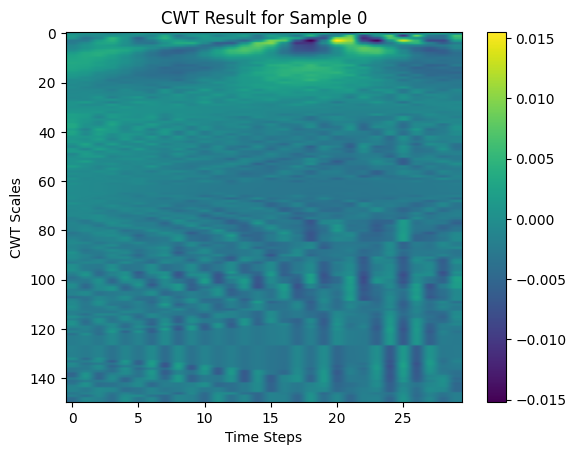

In [ ]:
# Visualize an example CWT result
sample_index = 0
plt.imshow(cwt_results[sample_index], aspect='auto', cmap='viridis')
print(f'label of sample no:{sample_index} =  {y[sample_index]}')
plt.title('CWT Result for Sample {}'.format(sample_index))
plt.xlabel('Time Steps')
plt.ylabel('CWT Scales')
plt.colorbar()
plt.show()

In [ ]:
# cwt_results.shape, sobi_result.shape, ica_result.shape
cwt_results.shape

(3600, 150, 30)

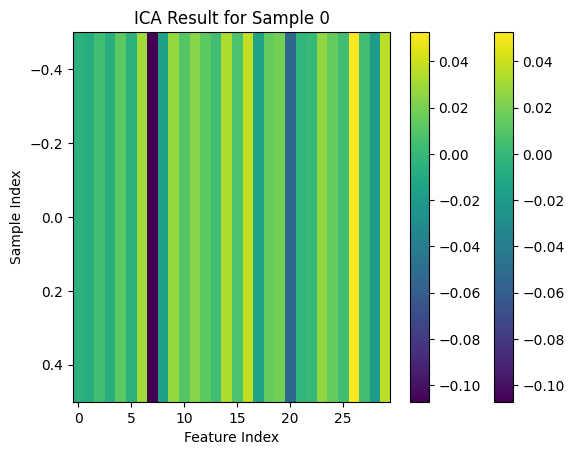

In [ ]:
# Create a heatmap-style plot
sample_index = 0
plt.imshow(ica_result[sample_index:1], aspect='auto', cmap='viridis')
plt.colorbar()  # Add a colorbar for reference
plt.title('ICA Result for Sample {}'.format(sample_index))
plt.xlabel("Feature Index")
plt.ylabel("Sample Index")
plt.colorbar()
plt.show()


In [ ]:
def local_binary_count(pixel_values, center_value):
    binary_values = (pixel_values >= center_value).astype(int)
    decimal_values = np.sum(binary_values * 2**np.arange(len(pixel_values)))
    return decimal_values

def local_neighbor_descriptive_count(pixel_values):
    binary_values = (pixel_values[:-1] >= pixel_values[1:]).astype(int)
    decimal_values = np.sum(binary_values * 2**(len(pixel_values)-2 - np.arange(len(binary_values))))
    return decimal_values

def local_gradient_count(pixel_values, center_value):
    gradient_values = np.abs(pixel_values - center_value)
    average_gradient = np.mean(gradient_values)
    binary_values = (gradient_values >= average_gradient).astype(int)
    decimal_value = np.sum(binary_values * 2**np.arange(len(pixel_values)))
    return decimal_value

In [ ]:
# Applying transformations to the CWT output
transformed_output = np.zeros((cwt_results.shape[0], cwt_results.shape[1], cwt_results.shape[2], 3), dtype=int)  # Create an array to store the transformed values

for i in range(cwt_results.shape[0]):
    for j in range(cwt_results.shape[1]):
        for k in range(cwt_results.shape[2]):
            pixel_values = cwt_results[i, j, :]
            center_value = pixel_values[k]

            lbc_decimal = local_binary_count(pixel_values, center_value)
            lndc_decimal = local_neighbor_descriptive_count(pixel_values)
            lgc_decimal = local_gradient_count(pixel_values, center_value)

            transformed_output[i, j, k] = [lbc_decimal, lndc_decimal, lgc_decimal]

In [ ]:
transformed_output.shape

(850, 50, 30, 3)

the label of Sample 100 = 1


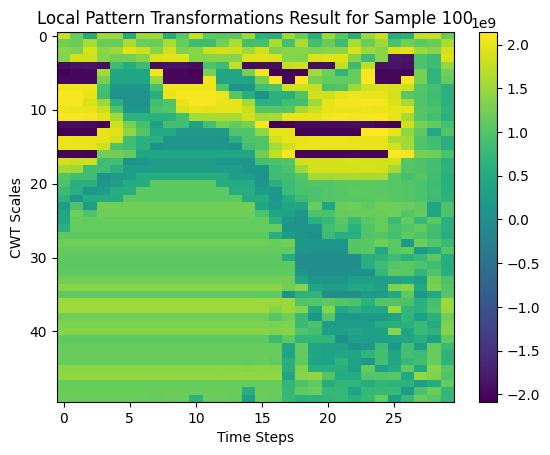

In [ ]:
# Choose an index for each technique
lbc_index = 0
lndc_index = 1
lgc_index = 2

combined_transform = (
    transformed_output[:, :, :, lbc_index] +
    transformed_output[:, :, :, lndc_index] +
    transformed_output[:, :, :, lgc_index]
)
# Visualize an example CWT result
sample_index = 100
print(f'the label of Sample {sample_index} = {y[sample_index]}')
plt.imshow(combined_transform[sample_index], aspect='auto', cmap='viridis')
plt.title('Local Pattern Transformations Result for Sample {}'.format(sample_index))
plt.xlabel('Time Steps')
plt.ylabel('CWT Scales')
plt.colorbar()
plt.show()

In [ ]:
# Split the data randomly into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2,shuffle= True, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]),  recurrent_dropout=0.2, return_sequences=True))
# model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.45))
model.add(LSTM(32, recurrent_dropout=0.2, return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Binary classification

opt = Adam(learning_rate=0.0006)


# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
118/118 [==============================] - 58s 399ms/step - loss: 0.5299 - accuracy: 0.7198 - val_loss: 0.4601 - val_accuracy: 0.7713
Epoch 2/20
118/118 [==============================] - 36s 305ms/step - loss: 0.4470 - accuracy: 0.7773 - val_loss: 0.4443 - val_accuracy: 0.7723
Epoch 3/20
118/118 [==============================] - 36s 302ms/step - loss: 0.4301 - accuracy: 0.7815 - val_loss: 0.4361 - val_accuracy: 0.7840
Epoch 4/20
118/118 [==============================] - 34s 287ms/step - loss: 0.4226 - accuracy: 0.7906 - val_loss: 0.4253 - val_accuracy: 0.7936
Epoch 5/20
118/118 [==============================] - 33s 283ms/step - loss: 0.4127 - accuracy: 0.7919 - val_loss: 0.4351 - val_accuracy: 0.7883
Epoch 6/20
118/118 [==============================] - 54s 462ms/step - loss: 0.4072 - accuracy: 0.8047 - val_loss: 0.4250 - val_accuracy: 0.7915
Epoch 7/20
118/118 [==============================] - 59s 501ms/step - loss: 0.4011 - accuracy: 0.8015 - val_loss: 0.4175 - val_ac

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

30/30 [==============================] - 1s 39ms/step - loss: 0.4505 - accuracy: 0.7947


Test accuracy: 0.7946808338165283
Kappa: 0.5861241399448834
F1 Score: 0.8128031037827352
Precision: 0.7846441947565543
Recall: 0.8430583501006036


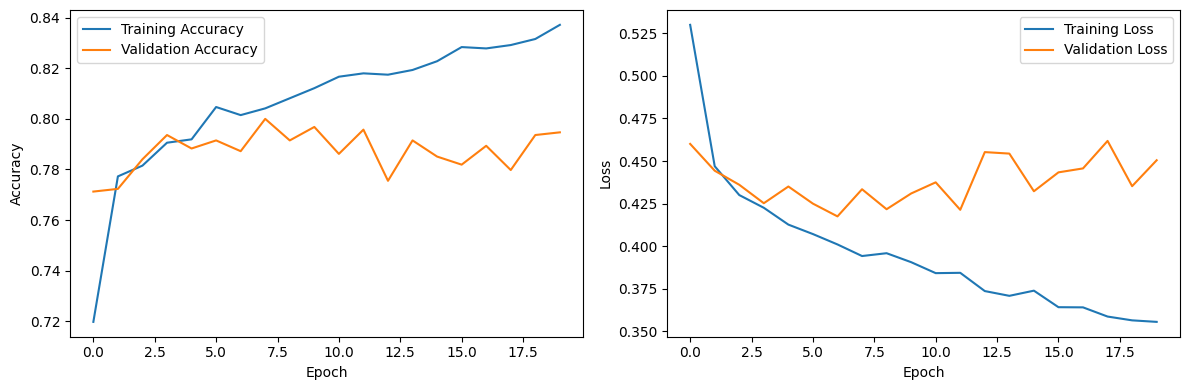

In [ ]:
print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

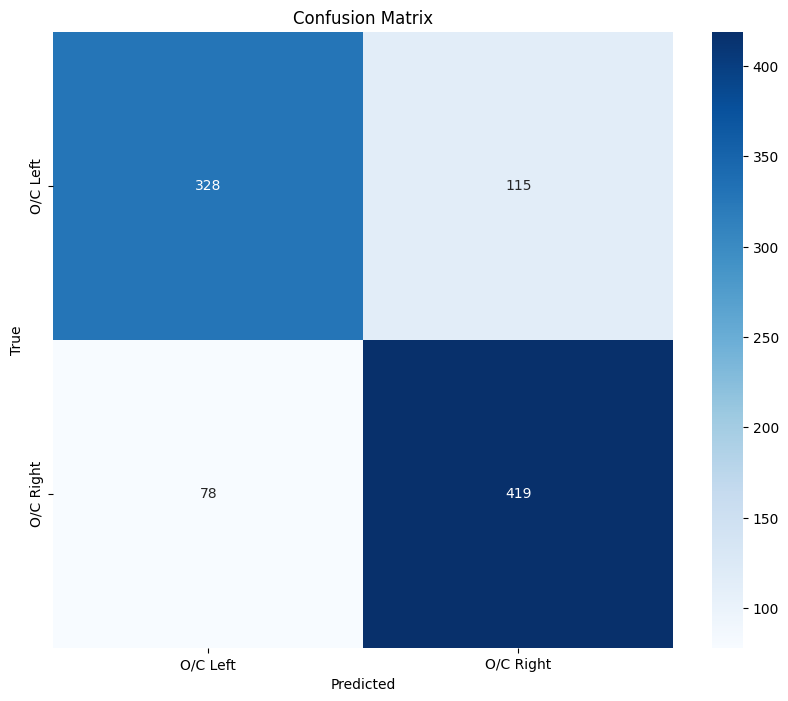

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Reshape input data to have the correct shape
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.45))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.2, return_sequences=True)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Binary classification

opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_Bi = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/20
118/118 [==============================] - 58s 357ms/step - loss: 0.5315 - accuracy: 0.7142 - val_loss: 0.4510 - val_accuracy: 0.7979
Epoch 2/20
118/118 [==============================] - 29s 242ms/step - loss: 0.4412 - accuracy: 0.7810 - val_loss: 0.4181 - val_accuracy: 0.7979
Epoch 3/20
118/118 [==============================] - 28s 241ms/step - loss: 0.4257 - accuracy: 0.7935 - val_loss: 0.4254 - val_accuracy: 0.8043
Epoch 4/20
118/118 [==============================] - 32s 276ms/step - loss: 0.4145 - accuracy: 0.7924 - val_loss: 0.4299 - val_accuracy: 0.7851
Epoch 5/20
118/118 [==============================] - 29s 244ms/step - loss: 0.4110 - accuracy: 0.7956 - val_loss: 0.4396 - val_accuracy: 0.7862
Epoch 6/20
118/118 [==============================] - 29s 243ms/step - loss: 0.4110 - accuracy: 0.7980 - val_loss: 0.4443 - val_accuracy: 0.7830
Epoch 7/20
118/118 [==============================] - 28s 242ms/step - loss: 0.4003 - accuracy: 0.8012 - val_loss: 0.4319 - val_ac

30/30 [==============================] - 1s 44ms/step - loss: 0.4903 - accuracy: 0.7936
Test accuracy: 0.7936170101165771
Kappa: 0.5843381457961989
F1 Score: 0.810546875
Precision: 0.7874762808349146
Recall: 0.8350100603621731


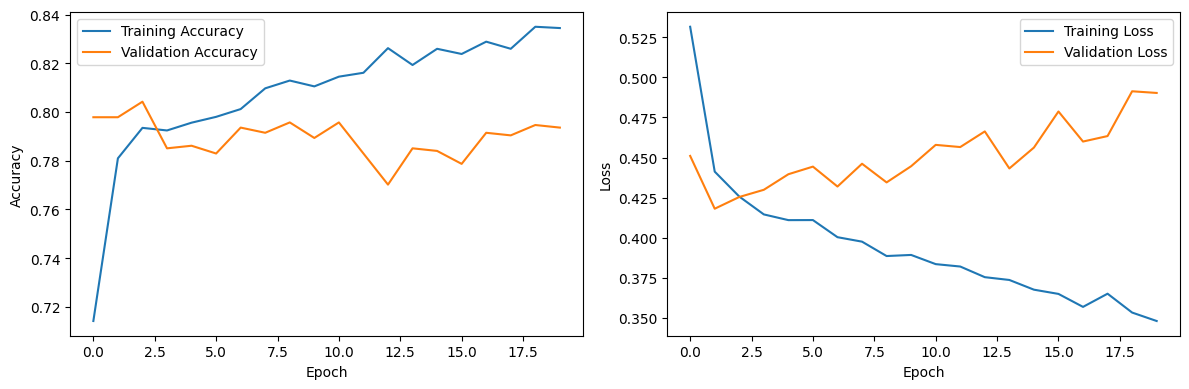

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Bi.history['accuracy'], label='Training Accuracy')
plt.plot(history_Bi.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Bi.history['loss'], label='Training Loss')
plt.plot(history_Bi.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

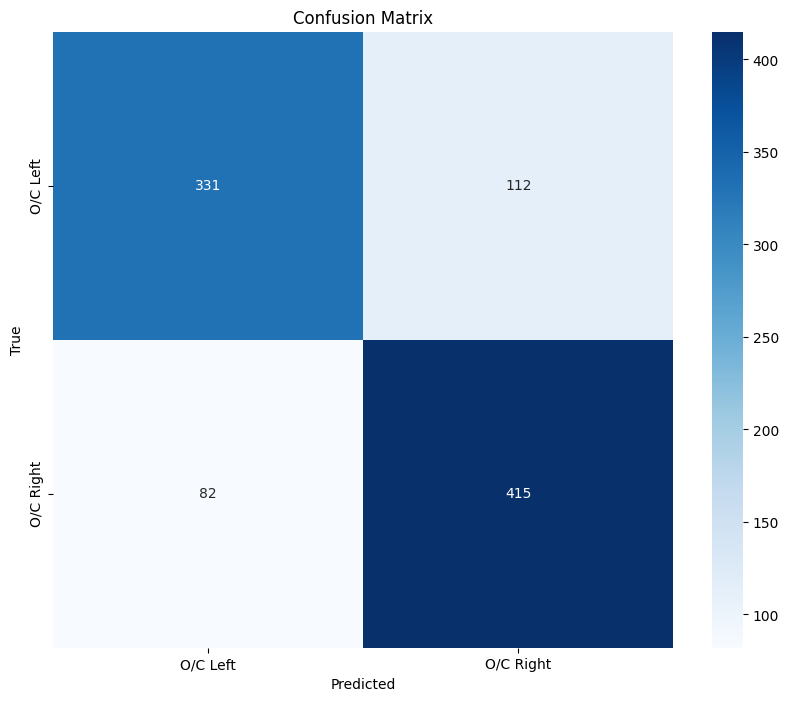

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Define the Deep Neural Network (DNN) model
model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))  # Flatten the CWT data
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.55))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))  # Dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_dnn = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/40
118/118 [==============================] - 2s 11ms/step - loss: 0.7278 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.4702
Epoch 2/40
118/118 [==============================] - 1s 9ms/step - loss: 0.6932 - accuracy: 0.5075 - val_loss: 0.6934 - val_accuracy: 0.4713
Epoch 3/40
118/118 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6935 - val_accuracy: 0.4713
Epoch 4/40
118/118 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6936 - val_accuracy: 0.4713
Epoch 5/40
118/118 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6937 - val_accuracy: 0.4713
Epoch 6/40
118/118 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6937 - val_accuracy: 0.4713
Epoch 7/40
118/118 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6937 - val_accuracy: 0.4713
Epo

30/30 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4713


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy: 0.47127658128738403
Kappa: 0.0
F1 Score: 0.0
Precision: 0.0
Recall: 0.0


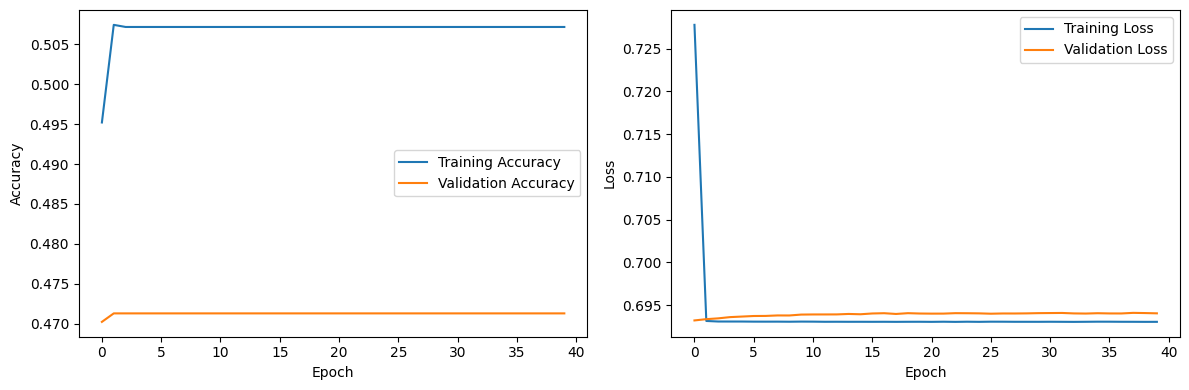

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define the advanced 1D CNN model
# Define the advanced 1D CNN model
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.45),
    Conv1D(32, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    MaxPooling1D(pool_size=2),
    Dropout(0.45),
    Flatten(),
    # Dense(64, activation='relu'),
    # Dropout(0.55),
    Dense(32, activation='relu'),
    Dropout(0.55),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
118/118 [==============================] - 7s 22ms/step - loss: 0.6975 - accuracy: 0.5293 - val_loss: 0.6671 - val_accuracy: 0.7319
Epoch 2/50
118/118 [==============================] - 2s 16ms/step - loss: 0.5987 - accuracy: 0.6873 - val_loss: 0.5274 - val_accuracy: 0.7660
Epoch 3/50
118/118 [==============================] - 2s 16ms/step - loss: 0.5465 - accuracy: 0.7347 - val_loss: 0.5232 - val_accuracy: 0.7851
Epoch 4/50
118/118 [==============================] - 2s 20ms/step - loss: 0.5271 - accuracy: 0.7363 - val_loss: 0.5401 - val_accuracy: 0.7755
Epoch 5/50
118/118 [==============================] - 3s 23ms/step - loss: 0.5198 - accuracy: 0.7435 - val_loss: 0.5186 - val_accuracy: 0.7777
Epoch 6/50
118/118 [==============================] - 3s 23ms/step - loss: 0.5096 - accuracy: 0.7440 - val_loss: 0.5059 - val_accuracy: 0.7872
Epoch 7/50
118/118 [==============================] - 2s 18ms/step - loss: 0.5109 - accuracy: 0.7536 - val_loss: 0.5038 - val_accuracy: 0.7798

30/30 [==============================] - 0s 3ms/step - loss: 0.5355 - accuracy: 0.7511
Test accuracy: 0.7510638236999512
Kappa: 0.49086397577923546
F1 Score: 0.7961672473867596
Precision: 0.7019969278033794
Recall: 0.9195171026156942


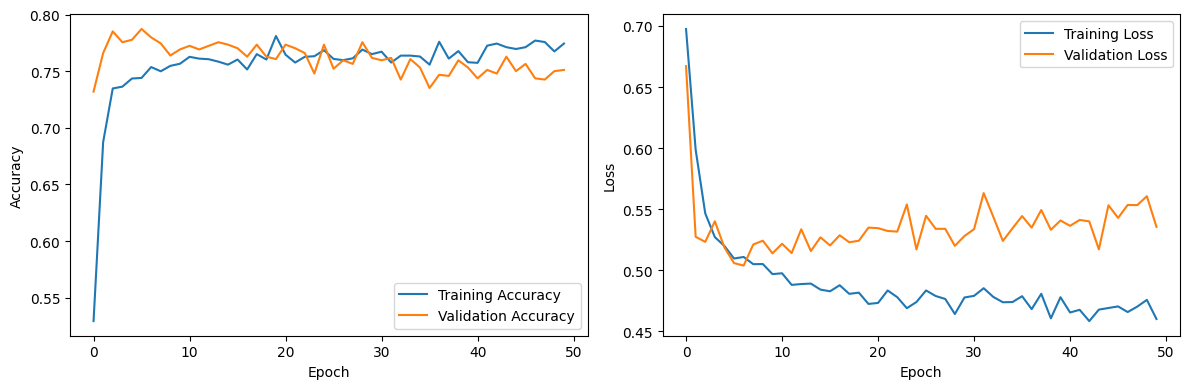

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import GRU
# tensorflow.random.set_seed(42)

# Define the advanced 1D CNN model with a GRU layer
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    GRU(32,recurrent_dropout=0.25, return_sequences=True),  # Adding a GRU layer with 64 units
    Dropout(0.3),
    # GRU(32,recurrent_dropout=0.25, return_sequences=True),  # Adding a GRU layer with 64 units
    # Dropout(0.3),
    # GRU(16,recurrent_dropout=0.25, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_gru = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/55
118/118 [==============================] - 15s 82ms/step - loss: 0.6961 - accuracy: 0.5261 - val_loss: 0.6691 - val_accuracy: 0.6787
Epoch 2/55
118/118 [==============================] - 7s 57ms/step - loss: 0.5794 - accuracy: 0.6972 - val_loss: 0.4858 - val_accuracy: 0.7660
Epoch 3/55
118/118 [==============================] - 11s 93ms/step - loss: 0.4973 - accuracy: 0.7501 - val_loss: 0.4580 - val_accuracy: 0.7819
Epoch 4/55
118/118 [==============================] - 7s 62ms/step - loss: 0.4724 - accuracy: 0.7589 - val_loss: 0.4540 - val_accuracy: 0.7830
Epoch 5/55
118/118 [==============================] - 9s 75ms/step - loss: 0.4569 - accuracy: 0.7805 - val_loss: 0.4475 - val_accuracy: 0.7904
Epoch 6/55
118/118 [==============================] - 6s 47ms/step - loss: 0.4583 - accuracy: 0.7757 - val_loss: 0.4480 - val_accuracy: 0.7883
Epoch 7/55
118/118 [==============================] - 4s 37ms/step - loss: 0.4525 - accuracy: 0.7738 - val_loss: 0.4467 - val_accuracy: 0.78

30/30 [==============================] - 1s 16ms/step - loss: 0.4341 - accuracy: 0.7883
Test accuracy: 0.7882978916168213
Kappa: 0.5760775959751621
F1 Score: 0.7963152507676561
Precision: 0.8104166666666667
Recall: 0.7826961770623743


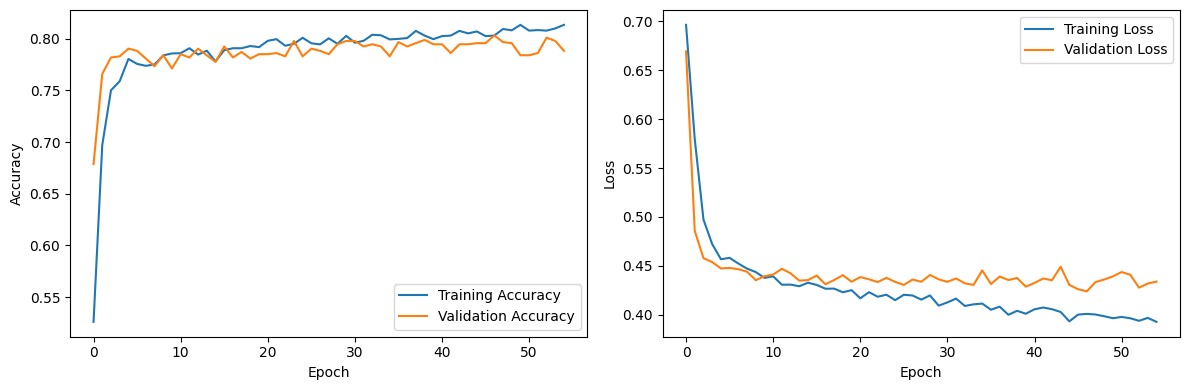

In [ ]:
 # Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_gru.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_gru.history['loss'], label='Training Loss')
plt.plot(history_cnn_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

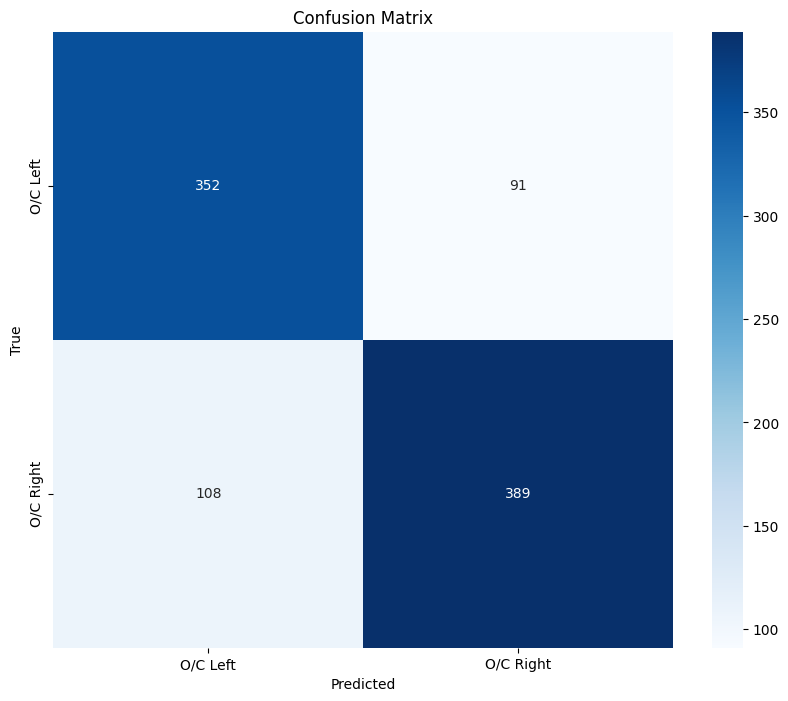

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()